# GRAD_CAM

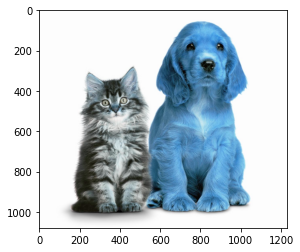

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('./data/catdog.jpg')

plt.imshow(image)
plt.show()

# 중간계층 시각화 

In [3]:
import numpy as np
import tensorflow as tf


# Model to examine
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv3_block4_2_relu (Activation (None, 28, 28, 128)  0           conv3_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________

Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________


In [17]:
IMAGE_PATH = './data/catdog.jpg'

# Image to pass as input
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

In [22]:
# Get the outputs of layers we want to inspect
layers_name = ['conv1_relu']

outputs = [
    layer.output for layer in model.layers
    if layer.name in layers_name
]

In [23]:
# Create a connection between the input and those target outputs
activations_model = tf.keras.models.Model(model.inputs, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations_1 = activations_model.predict(np.array([img]))

In [24]:
activations_1.shape

(1, 112, 112, 64)

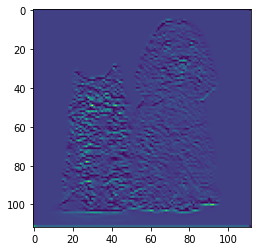

In [25]:
plt.imshow(activations_1[0,:, :,-1])

# 커널 조사

In [26]:
import numpy as np
import tensorflow as tf

# Layer name to inspect
layer_name = 'conv4_block2_1_conv'

epochs = 100
step_size = 1.
filter_index = 0

# Create a connection between the input and the target layer
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)
submodel = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])

# Initiate random noise
input_img_data = np.random.random((1, 224, 224, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128.

# Cast random noise from np.float64 to tf.float32 Variable
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
for _ in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
    grads = tape.gradient(loss_value, input_img_data)
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)


In [27]:
input_img_data.shape

TensorShape([1, 224, 224, 3])

In [28]:
new_img=input_img_data[0,:,:,0]+input_img_data[0,:,:,1]+input_img_data[0,:,:,2]

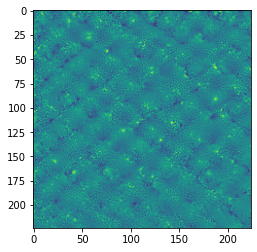

In [29]:
plt.imshow(new_img)

# 신경망의 결정을 어떻게 이뤄지나?

## 오클루전 민감도

In [30]:
import numpy as np
import tensorflow as tf

# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

# Load image
IMAGE_PATH = 'data/catdog2.jpg'
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Instantiate model
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

CAT_CLASS_INDEX = 281  # Imagenet tabby cat class index
PATCH_SIZE = 40

sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

# Iterate the patch over the image
for top_left_x in range(0, img.shape[0], PATCH_SIZE):
    for top_left_y in range(0, img.shape[1], PATCH_SIZE):
        patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
        predicted_classes = model.predict(np.array([patched_image]))[0]
        confidence = predicted_classes[CAT_CLASS_INDEX]
        
        # Save confidence for this specific patched image in map
        sensitivity_map[
            top_left_y:top_left_y + PATCH_SIZE,
            top_left_x:top_left_x + PATCH_SIZE,
        ] = confidence


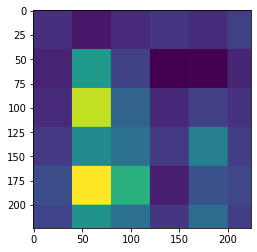

In [31]:
plt.imshow(sensitivity_map)

# 클래스 활동 맵 (CAM: Class Activation Maps)

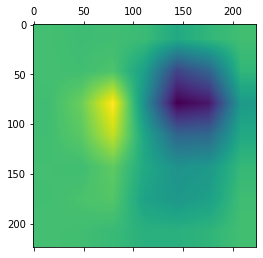

In [32]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = 'data/catdog.jpg'
LAYER_NAME = 'conv5_block3_out'
CAT_CLASS_INDEX = 281

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Load initial model
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

# Create a graph that outputs target convolution and output
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

# Get the score for target class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

# Extract filters and gradients
output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

# Average gradients spatially
weights = tf.reduce_mean(grads, axis=(0, 1))

# Build a ponderated map of filters according to gradients importance
cam = np.ones(output.shape[0:2], dtype=np.float32)

for index, w in enumerate(weights):
    cam += w * output[:, :, index]

# Heatmap visualization
cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [33]:
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)


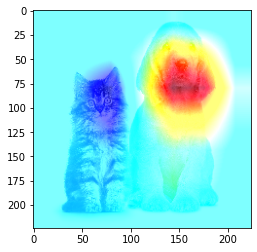

In [34]:
plt.imshow(output_image)

# 지도 역전파 (Guided backpropagation)

In [38]:
import cv2
import numpy as np
import tensorflow as tf

IMAGE_PATH = 'data/catdog.jpg'
#LAYER_NAME = 'conv5_block3_out'
LAYER_NAME='conv4_block2_1_conv'
CAT_CLASS_INDEX = 281

img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

# Load initial model
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (224, 224))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

cv2.imwrite('cam.png', output_image)

True

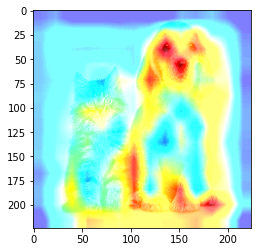

In [39]:
plt.imshow(output_image)

#### 원이미지 비교

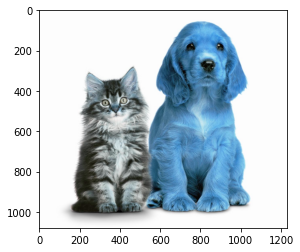

In [37]:
image = cv2.imread('data/catdog.jpg')
plt.imshow(image)
plt.show()